<p class="title"> Duality between confidence sets and hypothesis tests</p>

### We will observe $X \sim \mathbb P_\mu$, where $\mu \in \Theta$.  
+ $\Theta$ is known
+ $\theta \rightarrow \mathbb P_\theta$ is known
+ $\mu$ is unknown
+ $X$ takes values in $\mathcal X$.

(We will ignore issues of measurability here: tacitly assume that for all $\theta \in \Theta$, $A_\eta$ is $\mathbb P_\theta$-measurable
and that $\mathcal I(X)$ is set-valued $\mathbb P_\theta$-measurable function.)

<div class="definition">
$A_\theta \subset \mathcal X$ is the acceptance region for a level-$\alpha$ test of the hypothesis $\mu = \theta$ iff
$$\mathbb P_\theta (X \notin A_\theta) \le \alpha.$$
</div>

<p class="gap01"></p>

<div class="definition">
$\mathcal I(X)$ is a $1-\alpha$ confidence set for $\mu$ iff 
$$ \forall \theta \in \Theta, \;\;\; \mathbb P_\theta ( \mathcal I(X) \ni \theta) \ge 1-\alpha.$$
</div>

<p class="gap01"></p>

<div class="proposition">
Suppose 
$$\{A_\theta: \theta \in \Theta \}$$
is a family of level-$\alpha$ acceptance regions. Then 
$$ \mathcal I(X) \equiv \{ \theta \in \Theta: X \in A_\theta \}$$
is a $1-\alpha$ confidence set for $\mu$.
</div>

<div class="proof">
 For any $\theta \in \Theta$,
   $$ \mathbb P_\theta \left (\{ \eta \in \Theta: X \in A_\eta \} \ni \theta \right )  = 
        \mathbb P_\theta ( X \in A_\theta ) $$
   $$ \ge 1-\alpha.$$
</div>

## We will use this approach&mdash;inverting tests&mdash;to construct confidence sets.

+ We are interested in _confidence bounds_ for real-valued parameters, typically 1-sided bounds
+ Typically, one-sided tests for a one-dimensional location parameter lead to one-sided confidence bounds for the parameter
+ Inverting a family of tests that rejects $\mu = \theta$ when $X$ is sufficiently small typically leads to an _upper_ confidence bound for $\mu$
+ Inverting a family of tests that rejects $\mu = \theta$ when $X$ is sufficiently large typically leads to a _lower_ confidence bound for $\mu$
+ Inverting a family of tests that rejects $\mu = \theta$ when $X$ is sufficiently "extreme" typically leads to a confidence interval for $\mu$

(Exceptions arise from non-monotone likelihood ratios, etc.)

## Example: one-sided binomial tests

Consider $n$ independent, uniform draws (i.e., a random sample with replacement) from a $\{0, 1\}$ population containing a fraction $p$ of 1s.
Let $X$ denote the number of 1s in the random sample. Then $X$ has a Binomial distribution with parameters $n$ and $p$.

In particular,
$$ \mathbb P_{n,p} (X = k) = {n \choose k} p^k (1-p)^{n-k}$$
for $0 \le k \le n$.

To find a one-sided lower confidence bound for $p$ in a Binomial$(n,p)$ distribution, with $n$ known, we would invert one-sided upper tests, that is, tests that reject the hypothesis $p = \pi$ when $X$ is large.

The form of the acceptance region for the test is:
$$ A_\pi \equiv \ [0, a_\pi],$$
where 
$$ a_\pi \equiv \min \left \{ k: \sum_{i=k+1}^n {{n}\choose{i}} \pi^i (1-\pi)^{n-i} \le \alpha \right \}.$$

Let's see this graphically:

In [1]:
# This is the first cell with code: set up the Python environment
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import scipy.stats
from scipy.stats import binom
import pandas as pd
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

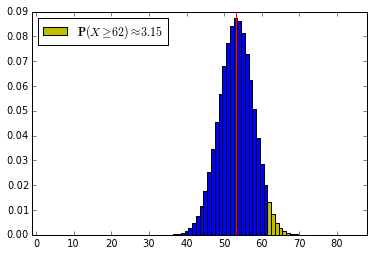

In [2]:
def binomialHiLite(n, p, alpha):
    ''' 
       Plots probability histogram for a binomial with parameters n and p, 
       highlighting the upper alpha quantile in yelow.
       The blue region corresponds to the acceptance region for a level-alpha
         test about p.
       Plots a red vertical line at the expected value.
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1)
    x = np.arange(n+1)
    val = binom.ppf(1-alpha, n, p)
    inx = np.searchsorted(x, val, side="right")
    xb = x[:inx]
    xy = x[inx:]
    width = 1.0
    ax.bar(xb, binom.pmf(xb, n, p), width, color='b', align='center')
    hilit = ax.bar(xy, binom.pmf(xy, n, p), width, color='y', align='center')
    plt.xlim([-width,n+width])
    plt.axvline(x=n*p, color='r')
    probStr = str(round(100*(1-binom.cdf(x[inx-1],n, p)),2))
    label = r'$\mathbf{P}(X \geq ' + str(x[inx]) + r') \approx' + probStr + '$'
    plt.legend([hilit[0]], [label], loc = 'best')

interact(binomialHiLite, n=widgets.IntSliderWidget(min=5, max=300, step=1, value=30),\
         p=widgets.FloatSliderWidget(min=0.001, max=1, step=0.001, value=.5),\
         alpha=widgets.FloatSliderWidget(min=0.0, max=1.0, step=0.001, value=.05)\
        )

## Inverting the test to find a confidence bound
To turn this family of tests into a lower confidence bound, we need to find
$$ \min \{ \pi: A_\pi \ni X \},$$
that is,
$$ \min \left \{ \pi: \sum_{i=X}^n {{n}\choose{i}} \pi^i (1-\pi)^{n-i} > \alpha \right \}.$$

The following code implements this, using a bisection search.

In [3]:
def bisect(lo, hi, tol, fun):
    mid = (lo+hi)/2.0
    while (hi-lo)/2 > tol:
        if fun(mid) == 0.0:
            return mid
        elif fun(lo)*fun(mid) < 0.0:
            hi = mid
        else:
            lo = mid
        mid = (lo+hi)/2.0
    return mid
        
def binoLowerCL(n, x, cl = 0.975, inc=0.000001, p = None):
    "Lower confidence level cl confidence interval for Binomial p, for x successes in n trials"
    if p is None:
            p = float(x)/float(n)
    lo = 0.0
    if (x > 0):
            f = lambda q: cl - scipy.stats.binom.cdf(x-1, n, q)
            lo = bisect(0.0, p, inc, f)
    return lo

Let's use the code to find a lower confidence bound for $p$ if 50 iid draws from a {0, 1} population yield 40 1s and 10 0s.

In [4]:
p_lower_bound = binoLowerCL(50, 40, cl=0.95)
print p_lower_bound

0.68440322876


Now let's check that against the probability histogram. Note that reducing $p$ below $0.6844$ drops the upper tail probability below 5%; for $p > 0.6844$ the probability is at least 5%, so the confidence interval is $[0.6844, 1]$:

<function __main__.binomialHiLite>

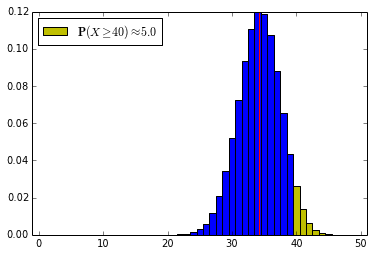

In [5]:
interact(binomialHiLite, n=widgets.IntSliderWidget(min=5, max=300, step=1, value=50),\
         p=widgets.FloatSliderWidget(min=0.001, max=1, step=0.001, value=p_lower_bound),\
         alpha=widgets.FloatSliderWidget(min=0.0, max=1.0, step=0.001, value=.05)\
        )

## Upper confidence bounds for $p$
For completeness, here's the code to find an upper confidence bound for Binomial $p$:

In [6]:
def binoUpperCL(n, x, cl = 0.975, inc=0.000001, p = None):
    "Upper confidence level cl confidence interval for Binomial p, for x successes in n trials"
    if p is None:
            p = float(x)/float(n)
    hi = 1.0
    if (x < n):
            f = lambda q: scipy.stats.binom.cdf(x, n, q) - (1-cl)
            hi = bisect(p, 1.0, inc, f)
    return hi

## What's next?
We will consider some methods for constructing confidence bounds that work where the normal approximation failed, focusing at first on (lower) one-sided confidence intervals for the mean of bounded populations

- [Next: Binomial confidence intervals](binom.ipynb)
- [Previous: Confidence intervals based on the normal approximation](normApprox.ipynb)
- [Index](index.ipynb)

In [7]:
%run talkTools.py